In [48]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [49]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

from types import SimpleNamespace

In [50]:
args = SimpleNamespace()
args.paradigm = 'evoked'


In [51]:
opt_data = {}
for i in range(1,9):
    # with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
    # with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run011s_MSE_{i}.pkl','rb') as f:
    with open(f'{ROOT_PATH}/experimental/coin_{args.paradigm}_run012_MSE_{i}.pkl','rb') as f:
        opt_data[i] = pickle.load(f)

In [52]:
opt_data

{1: {'MSE':                     message: ['requested number of basinhopping iterations completed successfully']
                      success: True
                          fun: 0.0193122692951781
                            x: [-5.011e+00  1.374e-01  2.269e-01  1.080e+00]
                          nit: 300
        minimization_failures: 81
                         nfev: 30330
                         njev: 6066
   lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                                success: True
                                 status: 0
                                    fun: 0.0193122692951781
                                      x: [-5.011e+00  1.374e-01  2.269e-01
                                           1.080e+00]
                                    nit: 2
                                    jac: [ 9.508e+02  3.056e+04  6.360e+03
                                           1.628e+04]
                                   nfev: 115

In [53]:
def scale_and_bias(x,bias=0,scale=45.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}


fixed_params['model'] =  dict(n_inputs = 4,
                        n_hidden = 5*4*512,
                        n_outs = 1,
                        en_bias = False,
                        first_layer_init='uniform_unity',
                    first_layer_weights_trainable = True,
                    out_layer_init='zeros',
                        nl = 'relu')        

fixed_params['runner'] = {'criterion':'MSE', 'k':[0,0,0,1],  'sigma_noi':0.0, 'tau_u':1,
                        'save_model_at_init':False, 'ic_param_file':None, 'enable_combo':True}

optim_param_mapping= [('custom','normalized_log_lr'),
                    ('model','skip_gain'),                      
                    ('model','b_high'),                      
                    ('postprocessing','scale'),
                    ]
custom_param_mappings = [{'cathegory':'runner','param_name':'learning_rate',
                            'fun': lambda x: 10.**x['normalized_log_lr']}]

wrapped_runner = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [54]:
Pplus = 1
Pminus = -1
P0 = 0
Pchannel = np.nan

'''
spontaneous:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp150: 150


evoked:
trials in block Null: 50
trials in block FieldA: 120
trials in block PostRest: 5
trials in block FieldB: 15
trials in block Clamp2: 2
trials in block FieldA2: 2
trials in block Clamp150: 146
'''
stimuli = {'spontaneous': [(P0, 50),
                        (Pplus, 120),
                        (Pminus, 15),
                        (Pchannel, 150)],
            'evoked': [(P0, 50),
                        (Pplus, 125),
                        (Pminus, 15),
                        (Pchannel, 2),
                        (Pplus, 2),
                        (Pchannel, 146)]}

data = {}
for i in range(1,9):
    df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/COIN_data/trial_data_{args.paradigm}_recovery_participant{i}.csv')
    y = df.Adaptation.to_numpy()
    y *= np.sign(np.nansum(y))
    data[i] = y
stimulus = stimuli[args.paradigm]
datapoint_mapping=None

In [55]:
pooling_fun = 'MSE'

In [56]:
errors = [opt_data[k][pooling_fun]['fun'] for k in opt_data]


In [57]:
np.mean(errors)

0.014349895316478418

In [58]:
opt_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])

In [59]:
stimulus

[(0, 50), (1, 125), (-1, 15), (nan, 2), (1, 2), (nan, 146)]

In [60]:
# debu   = {k: wrapped_runner([stimulus],opt_data[k][pooling_fun]['x']) for k in opt_data}

In [61]:
outs  = {k: wrapped_runner(stimulus,opt_data[k][pooling_fun]['x']) for k in opt_data}

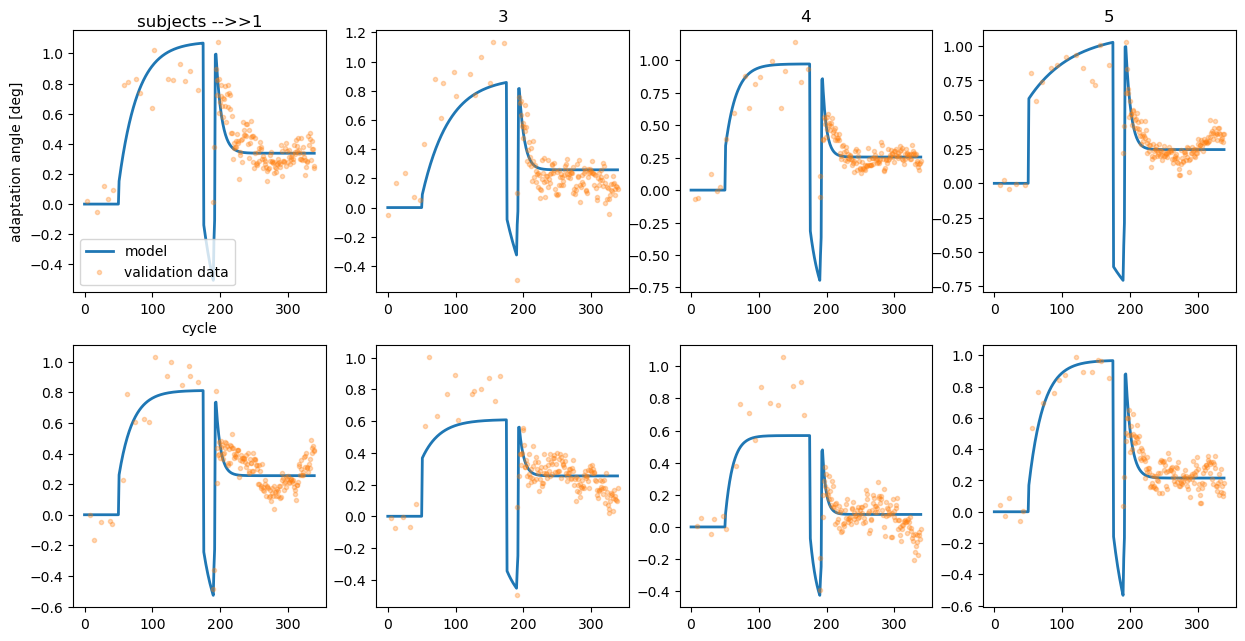

In [62]:
plt.figure(figsize=(15,7.5))
for k in opt_data:
    plt.subplot(2,4,k)
    plt.plot(outs[k],linewidth=2)
    plt.plot(data[k],'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
        

plt.subplot(2,4,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)
plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


In [63]:
outs_ = [o for _,o in outs.items()]
outs_ = np.array(outs_)
data_ = np.array([data[k] for k in opt_data])

/tmp/ipykernel_2538674/23407626.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(data_,axis=0),'.')


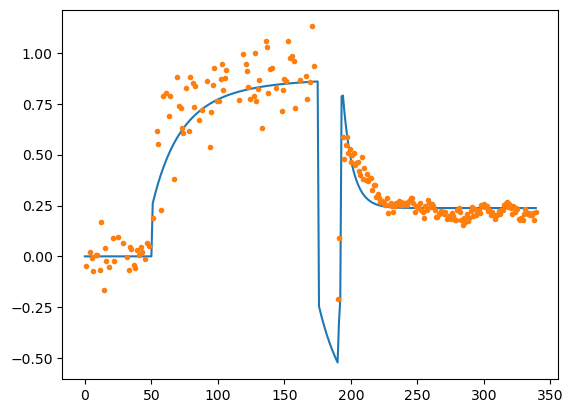

In [64]:
plt.plot(np.mean(outs_,axis=0))
plt.plot(np.nanmean(data_,axis=0),'.')

In [65]:
A_times = [0,5,10,20] 
antero   = {aa: [ wrapped_runner([(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,A_time in enumerate(A_times)}

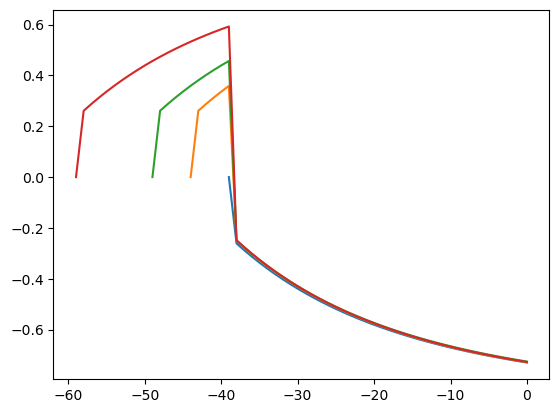

In [66]:
for aa,A_time in enumerate(A_times):
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    

In [67]:
frog_ens = [True,False]
Tfrog = 400
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

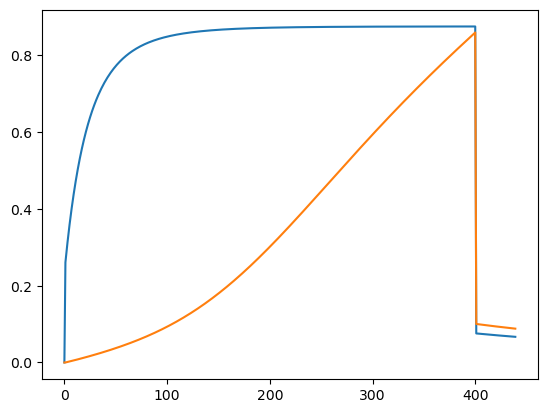

In [68]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))